https://docs.google.com/document/d/1h7w9xqNUQCZB_-DAv-5JD7gMpy-l1NuF0dZNP3PTKsA/edit

In [1]:
from datetime import date, datetime, timedelta
from collections import defaultdict
from scipy.optimize import minimize
from random import choices

import pandas as pd
import numpy as np
import statsmodels.api as sm
import scipy.optimize as opt
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
path_data=\
'/Users/rory/CUNY_Courses/EmpiricalAssetPricing/HW/Data/PredictorData2022.csv'

data=pd.read_csv(path_data)
data['yyyymm']=pd.to_datetime(data['yyyymm'], format='%Y%m')
data=data[(data['yyyymm'] >= datetime(1950,1,1))].reset_index(drop=True)
data['CRSP_SPvw_ExcessRet']=data['CRSP_SPvw']-data['Rfree']
data['Index']=data['Index'].apply(lambda x: float(x.replace(",", "")))
data['d/p']=data['D12']/data['Index']
data['e/p']=data['E12']/data['Index']
data['bondspread']=data['AAA']-data['tbl']
data['mm']=data['yyyymm'].apply(lambda x: x.month)

### Monthly

In [3]:
model01=sm.OLS(data['CRSP_SPvw_ExcessRet'],\
               data[['d/p', 'e/p', 'bondspread']]).fit()
model01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     CRSP_SPvw_ExcessRet   R-squared (uncentered):                   0.028
Model:                             OLS   Adj. R-squared (uncentered):              0.025
Method:                  Least Squares   F-statistic:                              8.372
Date:                 Sun, 24 Mar 2024   Prob (F-statistic):                    1.72e-05
Time:                         19:32:01   Log-Likelihood:                          1530.2
No. Observations:                  876   AIC:                                     -3054.
Df Residuals:                      873   BIC:                                     -3040.
Df Model:                            3                                                  
Covariance Type:             nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
d/p            0.1675      0.220      0.760      0.447      -0.265       0.600
e/p           -0.0637      0.105     -0.608      0.543      -0.269       0.142
bondspread     0.2227      0.073      3.055      0.002       0.080       0.366
==============================================================================
Omnibus:                       64.445   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.411
Skew:                          -0.456   Prob(JB):                     6.50e-30
Kurtosis:                       4.688   Cond. No.                         13.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [4]:
model02=sm.OLS(data['CRSP_SPvw_ExcessRet'],\
               data[['d/p', 'e/p', 'bondspread']]).fit(cov_type='HAC',
                                                       cov_kwds={'maxlags':1},
                                                       use_t=True)
model02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                 
========================================================================================
Dep. Variable:     CRSP_SPvw_ExcessRet   R-squared (uncentered):                   0.028
Model:                             OLS   Adj. R-squared (uncentered):              0.025
Method:                  Least Squares   F-statistic:                              6.877
Date:                 Sun, 24 Mar 2024   Prob (F-statistic):                    0.000140
Time:                         19:32:01   Log-Likelihood:                          1530.2
No. Observations:                  876   AIC:                                     -3054.
Df Residuals:                      873   BIC:                                     -3040.
Df Model:                            3                                                  
Covariance Type:                   HAC                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
d/p            0.1675      0.259      0.647      0.518      -0.341       0.676
e/p           -0.0637      0.131     -0.486      0.627      -0.321       0.193
bondspread     0.2227      0.083      2.671      0.008       0.059       0.386
==============================================================================
Omnibus:                       64.445   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.411
Skew:                          -0.456   Prob(JB):                     6.50e-30
Kurtosis:                       4.688   Cond. No.                         13.8
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 1 lags and without small sample correction
"""

### For Q3 and 4: Monthly

### Regression of one-year CRSP equal-weighted index real return on book-to-market

In [5]:
eq01=sm.OLS(data['CRSP_SPvw_ExcessRet'].iloc[:-1], sm.add_constant(data[['b/m']].iloc[:-1])).fit()
eq02=sm.OLS(data['b/m'].iloc[:-1], sm.add_constant(data[['b/m']].shift(-1).iloc[:-1])).fit()

In [6]:
# adjust the estimator of beta
T=data.shape[0]
p=eq01.pvalues.iloc[0]
pA=(T*p+1)/(T-3) # a bias-adjusted estimator for rho

b=eq01.params.iloc[1]
rho=eq02.params.iloc[1]
alpha=eq01.params.iloc[0]
theta=eq02.params.iloc[0]

s=np.cov(eq01.resid, eq02.resid)
s_epsilon_mu=s[0,1]
s_mu_2=s[1,1]
bA=b+(s_epsilon_mu/s_mu_2)*(1+3*pA)/T

print("beta (b) = {}, adjust the estimator of beta (b_A) = {}".format(b, bA))
print("rho = {}, a bias-adjusted estimator for rho = {}".format(rho, pA))
print("alpha = {}, theta = {}".format(alpha, theta))

epsilon_hat=eq01.resid
mu_hat=eq02.resid

beta (b) = -0.008810010639129801, adjust the estimator of beta (b_A) = -0.008765870667069206
rho = 0.9946190833494777, a bias-adjusted estimator for rho = 0.0017498333976895435
alpha = 0.01111134119876602, theta = 0.0033597254073386767


### Simulation Procedure

In [7]:
T=200
M=1000 # Simulation times
beta=0 # null hypothesis
rho=pA
beta_list=[]
pval_list=[]

for i in range(1, M):
    
    rand_list = choices(range(1, len(epsilon_hat)), k=T)
    r=alpha+beta+epsilon_hat[rand_list]
    x=theta+rho*data[['b/m']].shift(-1).iloc[:-1].values.T[0][rand_list]+mu_hat[rand_list]
    eq=sm.OLS(r, sm.add_constant(x)).fit()
    beta_list.append(eq.params[0])
    pval_list.append(eq.pvalues[0])

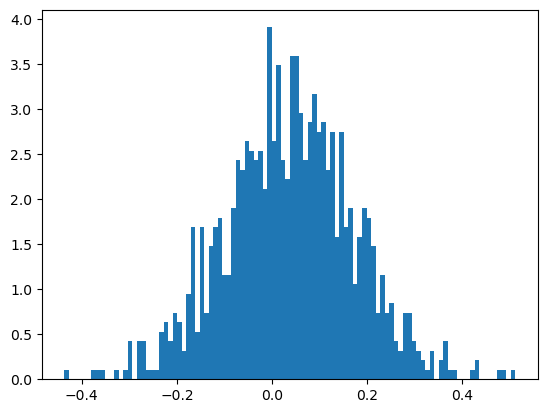

In [8]:
# We get an empirical distribution of b under the null.
count, bins, ignored = plt.hist(beta_list, 100, density=True)

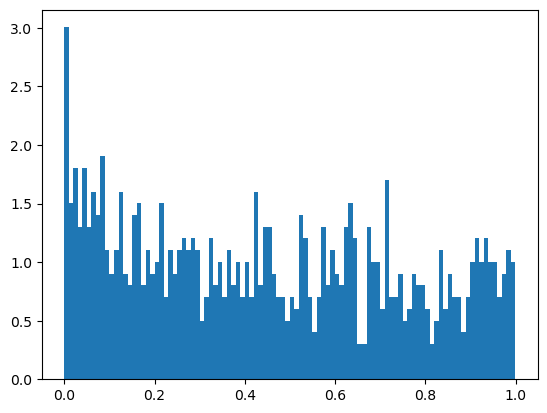

In [9]:
# p value based on the simulated empirical distribution of the point estimates
count, bins, ignored = plt.hist(pval_list, 100, density=True)

### For Q3 and 4: Quarterly

In [10]:
data_q=data[(data['mm']==3)|\
            (data['mm']==6)|\
            (data['mm']==9)|\
            (data['mm']==12)].reset_index(drop=True)

### Regression of one-year CRSP equal-weighted index real return on book-to-market

In [11]:
eq01=sm.OLS(data_q['CRSP_SPvw_ExcessRet'].iloc[:-1],\
            sm.add_constant(data_q[['b/m']].iloc[:-1])).fit()
eq02=sm.OLS(data_q['b/m'].iloc[:-1],\
            sm.add_constant(data_q[['b/m']].shift(-1).iloc[:-1])).fit()

In [12]:
# adjust the estimator of beta
T=data_q.shape[0]
p=eq01.pvalues.iloc[0]
pA=(T*p+1)/(T-3) # a bias-adjusted estimator for rho

b=eq01.params.iloc[1]
rho=eq02.params.iloc[1]
alpha=eq01.params.iloc[0]
theta=eq02.params.iloc[0]

s=np.cov(eq01.resid, eq02.resid)
s_epsilon_mu=s[0,1]
s_mu_2=s[1,1]
bA=b+(s_epsilon_mu/s_mu_2)*(1+3*pA)/T

print("beta (b) = {}, adjust the estimator of beta (b_A) = {}".format(b, bA))
print("rho = {}, a bias-adjusted estimator for rho = {}".format(rho, pA))
print("alpha = {}, theta = {}".format(alpha, theta))

epsilon_hat=eq01.resid
mu_hat=eq02.resid

beta (b) = -0.011782371834605974, adjust the estimator of beta (b_A) = -0.011998904457319503
rho = 0.9825325220235576, a bias-adjusted estimator for rho = 0.06917643354358285
alpha = 0.009455477634649488, theta = 0.010901170203535418


### Simulation Procedure

In [13]:
T=200
M=1000 # Simulation times
beta=0 # null hypothesis
rho=pA
beta_list=[]
pval_list=[]

for i in range(1, M):
    
    rand_list = choices(range(1, len(epsilon_hat)), k=T)
    r=alpha+beta+epsilon_hat[rand_list]
    x=theta+rho*data_q[['b/m']].shift(-1).iloc[:-1].values.T[0][rand_list]+mu_hat[rand_list]
    eq=sm.OLS(r, sm.add_constant(x)).fit()
    beta_list.append(eq.params[0])
    pval_list.append(eq.pvalues[0])

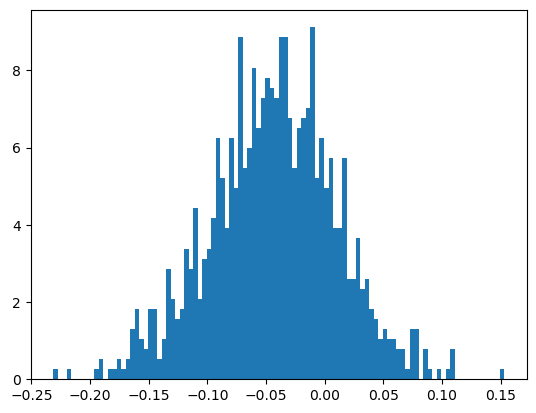

In [14]:
# We get an empirical distribution of b under the null.
count, bins, ignored = plt.hist(beta_list, 100, density=True)

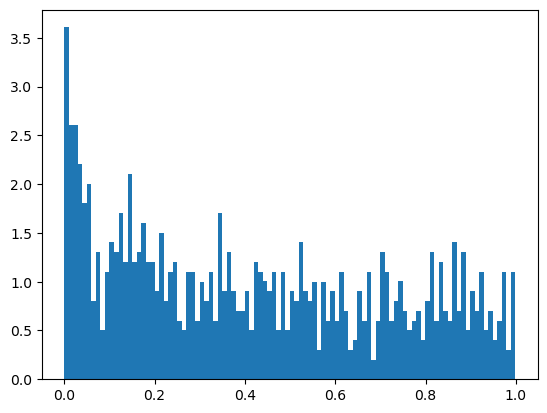

In [15]:
# p value based on the simulated empirical distribution of the point estimates
count, bins, ignored = plt.hist(pval_list, 100, density=True)